In [ ]:
import pickle
import datetime
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance
import optuna
import shap
from explainability import SHAP
from evaluation import evaluate_survival_model, PartialLogLikelihood
from training_survival_analysis import train_model
from models import MinimalisticNetwork

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [15]:
# ------------------------------
# 데이터 로딩 및 전처리 (공통)
# ------------------------------
df = pd.read_csv("processed_survival_data_modified.csv") # processed_survival_data_modified : Age 범주화한 데이터셋
df["survival"] = df["survival"].map({"survive": 0, "fail": 1}) # 종속변수(수술 성공 여부)를 0, 1로 변환

# 코드 통일성을 위해 생존기간, 성공여부 변수 이름 변경
time_col = "fu_total_yr"
event_col = "survival"
df.rename(columns={event_col: "vit_status", time_col: "survival_time"}, inplace=True)

# 분석 제외할 변수 제거
exclude_columns = ["patient_ID", "me", "failure_reason", "failure_date", 
                   "last_fu_date", "surgery_Date", "fu_for_fail_yr", "fu_for_survival_yr"]
selected_features = [col for col in df.columns if col not in ["vit_status", "survival_time"] + exclude_columns] # 분석에 사용할 변수만 포함

# 지정한 컬럼들에 결측치가 있는 행 제거
df = df.dropna(subset = selected_features)

# 평가 함수가 기대하는 구조화 배열 생성 (필드명: 'vit_status', 'survival_time')
y = np.zeros(df.shape[0], dtype=[('vit_status', '?'), ('survival_time', '<f8')])
y['vit_status'] = df["vit_status"].values.astype(bool)
y['survival_time'] = df["survival_time"].values.astype(float)

X = pd.get_dummies(df[selected_features], drop_first=True) # get_dummies : 범주형 변수에 대해 One-hot encoding

In [ ]:
# 설정
random_state = 1234
np.random.seed(random_state)
model_name = "rsf"

# ------------------------------
# 데이터 분할 및 K-Fold 설정
# ------------------------------

# Split between Test and Training for Hyperparameter Tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

# ------------------------------
# config.yaml 불러오기 및 RSF 파라미터 갱신
# ------------------------------
config = yaml.safe_load(Path("./config.yaml").read_text())
base_path = config["base_path"]
rsf_config = config["rsf"]
# 'max_features' 최대값은 선택한 특성의 개수로 갱신
rsf_config["max_features"]["max"] = len(selected_features)

In [ ]:
# ------------------------------
# Optuna Objective 함수 정의 (RSF)
# ------------------------------
def objective_rsf(trial: optuna.Trial):
    # Hyperparameter 범위 설정
    params = {
        "n_estimators": trial.suggest_int("n_estimators", rsf_config["n_estimators"]["min"], rsf_config["n_estimators"]["max"]),
        #"min_samples_split": trial.suggest_int("min_samples_split", max(2, rsf_config["min_samples_split"]["min"]), rsf_config["min_samples_split"]["max"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", rsf_config["min_samples_leaf"]["min"], rsf_config["min_samples_leaf"]["max"]),
        "max_features": trial.suggest_int("max_features", rsf_config["max_features"]["min"], rsf_config["max_features"]["max"]),
        "max_depth": trial.suggest_int("max_depth", rsf_config["max_depth"]["min"], rsf_config["max_depth"]["max"]),
        #"max_samples": trial.suggest_float("max_samples", rsf_config["max_samples"]["min"], rsf_config["max_samples"]["max"]),
    }
    scores = []
    
    # K-fold Cross Validation으로 계산한 K개의 Concordance index의 평균 계산
    for train_idx, _ in kfold.split(X_train, y_train):
        X_fold = X_train.iloc[train_idx]
        model = RandomSurvivalForest(
            n_estimators=params["n_estimators"],
            min_samples_leaf=params["min_samples_leaf"],
            max_features=params["max_features"],
            max_depth=params["max_depth"],
            n_jobs=-1,
            random_state=random_state
        )
        model.fit(X_fold, y_train[train_idx])
        score = model.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores) 

In [ ]:
# Optuna 스터디 생성 및 최적화
study = optuna.create_study(study_name=model_name+str(datetime.datetime.now()),
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective_rsf, n_trials=50)
best_params = study.best_trial.params
print("Best RSF parameters:", best_params) # 50번의 Trial로 찾은 최선의 Hyperparameter

In [ ]:
# 최종 모델 학습
for i, (train_fold , val_fold) in enumerate(kfold.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_fold]
    X_val_fold = X_train.iloc[val_fold]
    best_model = RandomSurvivalForest(**best_params, random_state=random_state, n_jobs=-1)
    best_model.fit(X_train_fold, y_train[train_fold])
    scores = evaluate_survival_model(best_model, X_val_fold, y_train[train_fold],
                                                    y_train[val_fold])
    print(f"Final RSF Scores in Fold {i}: {scores}")
    result = permutation_importance(
    best_model, X_val_fold, y_train[val_fold], n_repeats=15, random_state=random_state,
            )
    result_dict = {k: result[k] for k in ("importances_mean", "importances_std")}
    permutation_importances = pd.DataFrame(
            result_dict,
            index=X_val_fold.columns).sort_values(by="importances_mean", ascending=False)
    print(f"Permutation Importances:")
    print(permutation_importances)
    explainer = shap.Explainer(best_model.predict, X_val_fold)
    shap_values = explainer(X_val_fold)
    shap.plots.beeswarm(shap_values)

[I 2025-03-05 18:28:42,657] A new study created in memory with name: rsf2025-03-05 18:28:42.656648
[I 2025-03-05 18:28:44,736] Trial 0 finished with value: 0.6371212121212121 and parameters: {'n_estimators': 199, 'min_samples_leaf': 21, 'max_features': 7, 'max_depth': 12}. Best is trial 0 with value: 0.6371212121212121.
[I 2025-03-05 18:28:55,434] Trial 1 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 782, 'min_samples_leaf': 12, 'max_features': 5, 'max_depth': 13}. Best is trial 0 with value: 0.6371212121212121.
[I 2025-03-05 18:29:08,854] Trial 2 finished with value: 0.659090909090909 and parameters: {'n_estimators': 959, 'min_samples_leaf': 27, 'max_features': 6, 'max_depth': 9}. Best is trial 2 with value: 0.659090909090909.
[I 2025-03-05 18:29:18,000] Trial 3 finished with value: 0.6356060606060606 and parameters: {'n_estimators': 687, 'min_samples_leaf': 23, 'max_features': 6, 'max_depth': 9}. Best is trial 2 with value: 0.659090909090909.
[I 2025-03-05 

Best RSF parameters: {'n_estimators': 458, 'min_samples_leaf': 5, 'max_features': 11, 'max_depth': 3}
Final RSF Scores in Fold 0: {'c_index': 0.7615803814713896, 'mean_auc': 0.9138283658926137, 'ibs': 0.041491610136476904}
Permutation Importances:
                                          importances_mean  importances_std
prosthesis_type_single                            0.197820         0.087750
implant_site_p                                    0.140236         0.051655
periodontal_diagnosis_group_stage 3,4             0.041508         0.025160
Systemic_disease_y                                0.024523         0.051402
type_of_disability_Group2_Non-Mental              0.015804         0.012355
Age_old                                           0.009173         0.014128
jaw_mx                                            0.007084         0.008677
Sex_M                                             0.006085         0.011612
implant_diameter_group_regular: 4>= & 5<          0.004905         0

PermutationExplainer explainer: 99it [03:53,  2.48s/it]                        
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


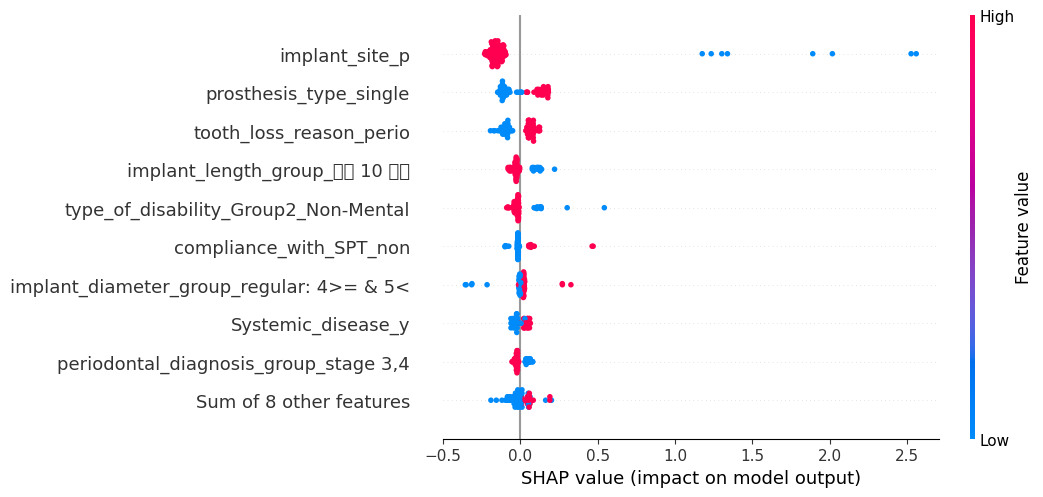

Final RSF Scores in Fold 1: {'c_index': 0.6723122238586157, 'mean_auc': 0.7089763012863516, 'ibs': 0.06553857382685595}
Permutation Importances:
                                          importances_mean  importances_std
implant_site_p                                    0.141483         0.036455
prosthesis_type_single                            0.051252         0.050648
tooth_loss_reason_perio                           0.012666         0.018379
type_of_disability_Group2_Non-Mental              0.010015         0.019219
jaw_mx                                            0.007020         0.005847
implant_diameter_group_wide: 5>=                  0.005940         0.007287
implant_length_group_길이 10 이상                     0.005596         0.009619
periodontal_diagnosis_group_stage 3,4             0.003191         0.020421
prosthesis_type_overdenture                      -0.001080         0.005588
Systemic_disease_y                               -0.002504         0.020062
Age_old            

PermutationExplainer explainer: 99it [03:56,  2.52s/it]                        


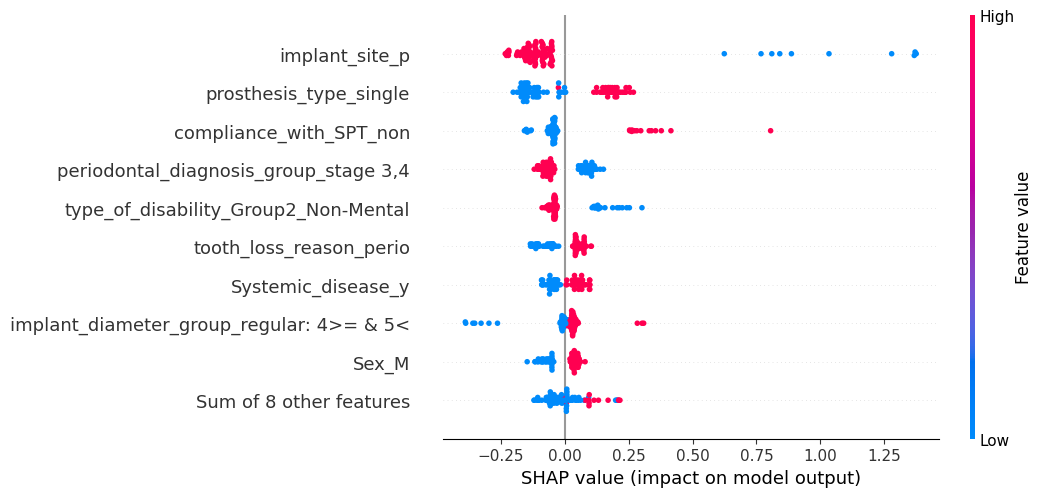

Final RSF Scores in Fold 2: {'c_index': 0.6197530864197531, 'mean_auc': 0.5872405218343107, 'ibs': 0.0382724717703555}
Permutation Importances:
                                          importances_mean  importances_std
implant_site_p                                    0.116296         0.101527
prosthesis_type_single                            0.049959         0.088174
periodontal_diagnosis_group_stage 3,4             0.022222         0.012995
type_of_disability_Group2_Non-Mental              0.012840         0.013394
implant_length_group_길이 10 이상                     0.007407         0.004876
compliance_with_SPT_erratic                       0.004362         0.005995
Sex_M                                             0.004033         0.004630
Systemic_disease_y                                0.003786         0.019771
Age_old                                           0.003292         0.013574
bone_augmentation_procedure_y                     0.002469         0.004300
prosthesis_type_over

PermutationExplainer explainer: 99it [03:57,  2.53s/it]                        


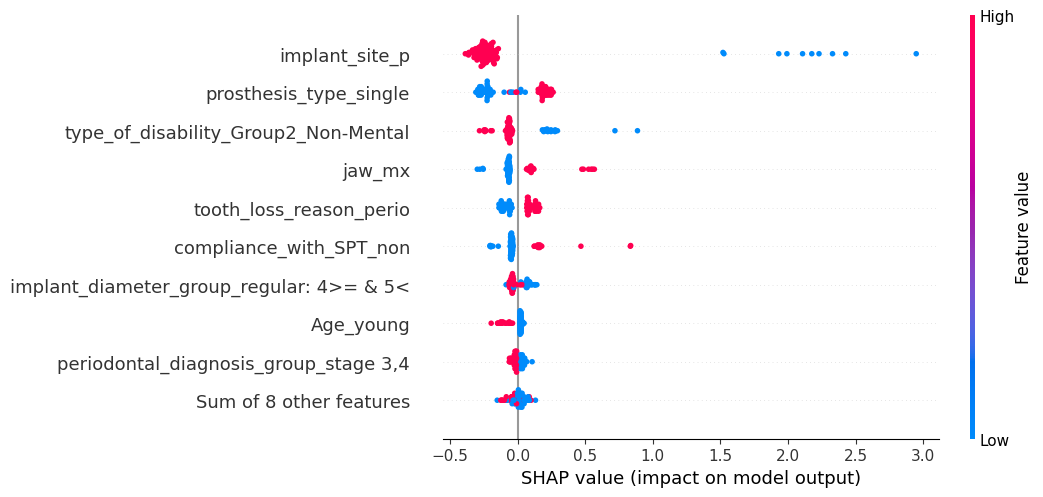

Final RSF Scores in Fold 3: {'c_index': 0.7673860911270983, 'mean_auc': 0.8207985677252414, 'ibs': 0.038066068246178184}
Permutation Importances:
                                          importances_mean  importances_std
implant_site_p                                    0.163389         0.081945
prosthesis_type_single                            0.132534         0.074870
Age_old                                           0.023501         0.028793
periodontal_diagnosis_group_stage 3,4             0.018705         0.015839
Systemic_disease_y                                0.014548         0.017934
tooth_loss_reason_perio                           0.012230         0.011888
implant_diameter_group_regular: 4>= & 5<          0.005436         0.017170
type_of_disability_Group2_Non-Mental              0.004476         0.011072
prosthesis_type_overdenture                       0.004157         0.022859
compliance_with_SPT_non                           0.001759         0.003863
Sex_M             

PermutationExplainer explainer: 99it [03:54,  2.50s/it]                        
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


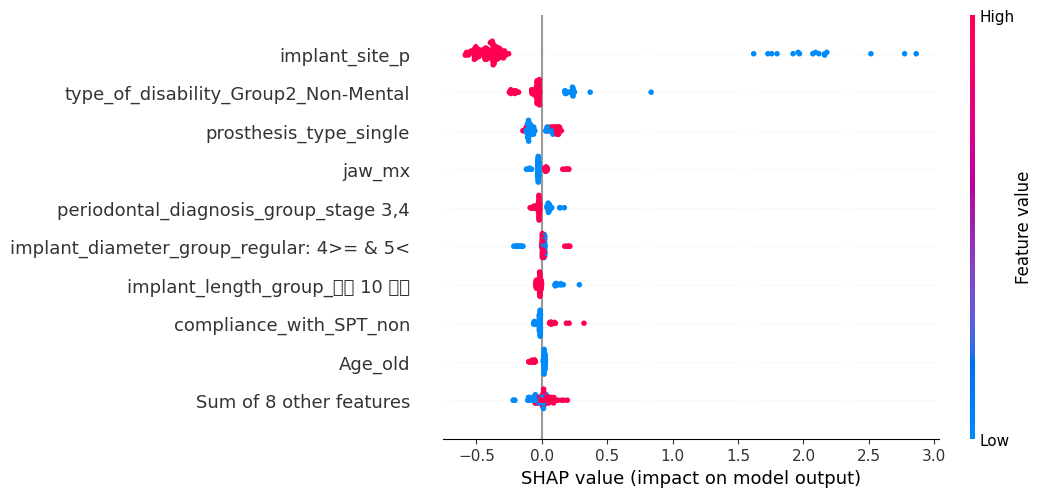

Final RSF Scores in Fold 4: {'c_index': 0.860655737704918, 'mean_auc': 0.8552665407392354, 'ibs': 0.026160327474855447}
Permutation Importances:
                                          importances_mean  importances_std
implant_site_p                                    0.474454         0.114319
prosthesis_type_single                            0.047814         0.049604
tooth_loss_reason_perio                           0.025683         0.011245
compliance_with_SPT_non                           0.023770         0.013234
Sex_M                                             0.014481         0.005961
Age_old                                           0.009563         0.011560
implant_length_group_길이 10 이상                     0.009016         0.005008
jaw_mx                                            0.007377         0.009606
bone_augmentation_procedure_y                     0.005738         0.003604
prosthesis_type_overdenture                       0.004918         0.004016
Age_young          

PermutationExplainer explainer: 98it [03:53,  2.51s/it]                        


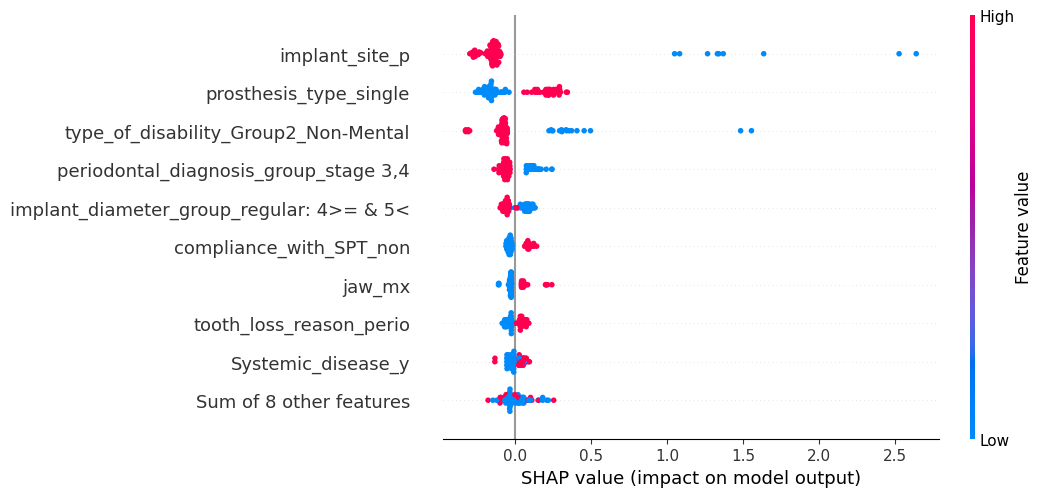

In [13]:
# 코드 종합

import pickle
import datetime
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
# 평가 함수 불러오기
from evaluation import evaluate_survival_model
from sklearn.inspection import permutation_importance
from explainability import SHAP
import shap
import optuna

# ------------------------------
# 데이터 로딩 및 전처리 (공통)
# ------------------------------
df = pd.read_csv("processed_survival_data_modified.csv") # processed_survival_data_modified : Age 범주화한 데이터셋
df["survival"] = df["survival"].map({"survive": 0, "fail": 1}) # 종속변수(수술 성공 여부)를 0, 1로 변환

# 코드 통일성을 위해 생존기간, 성공여부 변수 이름 변경
time_col = "fu_total_yr"
event_col = "survival"
df.rename(columns={event_col: "vit_status", time_col: "survival_time"}, inplace=True)

# 분석 제외할 변수 제거
exclude_columns = ["patient_ID", "me", "failure_reason", "failure_date", 
                   "last_fu_date", "surgery_Date", "fu_for_fail_yr", "fu_for_survival_yr"]
selected_features = [col for col in df.columns if col not in ["vit_status", "survival_time"] + exclude_columns] # 분석에 사용할 변수만 포함

# 지정한 컬럼들에 결측치가 있는 행 제거
df = df.dropna(subset = selected_features)

# 평가 함수가 기대하는 구조화 배열 생성 (필드명: 'vit_status', 'survival_time')
y = np.zeros(df.shape[0], dtype=[('vit_status', '?'), ('survival_time', '<f8')])
y['vit_status'] = df["vit_status"].values.astype(bool)
y['survival_time'] = df["survival_time"].values.astype(float)

X = pd.get_dummies(df[selected_features], drop_first=True) # get_dummies : 범주형 변수에 대해 One-hot encoding


# 설정
random_state = 1234
np.random.seed(random_state)
model_name = "rsf"

# ------------------------------
# 데이터 분할 및 K-Fold 설정
# ------------------------------

# Split between Test and Training for Hyperparameter Tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

# ------------------------------
# config.yaml 불러오기 및 RSF 파라미터 갱신
# ------------------------------
config = yaml.safe_load(Path("./config.yaml").read_text())
base_path = config["base_path"]
rsf_config = config["rsf"]
# 'max_features' 최대값은 선택한 특성의 개수로 갱신
rsf_config["max_features"]["max"] = len(selected_features)

# ------------------------------
# Optuna Objective 함수 정의 (RSF)
# ------------------------------
def objective_rsf(trial: optuna.Trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", rsf_config["n_estimators"]["min"], rsf_config["n_estimators"]["max"]),
        #"min_samples_split": trial.suggest_int("min_samples_split", max(2, rsf_config["min_samples_split"]["min"]), rsf_config["min_samples_split"]["max"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", rsf_config["min_samples_leaf"]["min"], rsf_config["min_samples_leaf"]["max"]),
        "max_features": trial.suggest_int("max_features", rsf_config["max_features"]["min"], rsf_config["max_features"]["max"]),
        "max_depth": trial.suggest_int("max_depth", rsf_config["max_depth"]["min"], rsf_config["max_depth"]["max"]),
        #"max_samples": trial.suggest_float("max_samples", rsf_config["max_samples"]["min"], rsf_config["max_samples"]["max"]),
    }
    scores = []
    for train_idx, _ in kfold.split(X_train, y_train):
        X_fold = X_train.iloc[train_idx]
        model = RandomSurvivalForest(
            n_estimators=params["n_estimators"],
            min_samples_leaf=params["min_samples_leaf"],
            max_features=params["max_features"],
            max_depth=params["max_depth"],
            n_jobs=-1,
            random_state=random_state
        )
        model.fit(X_fold, y_train[train_idx])
        score = model.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores)

# Create Study with objective "Maximize C-Index"
study = optuna.create_study(study_name=model_name+str(datetime.datetime.now()),
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective_rsf, n_trials=50)
best_params = study.best_trial.params
print("Best RSF parameters:", best_params)

# 최종 모델 학습
for i, (train_fold , val_fold) in enumerate(kfold.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_fold]
    X_val_fold = X_train.iloc[val_fold]
    best_model = RandomSurvivalForest(**best_params, random_state=random_state, n_jobs=-1)
    best_model.fit(X_train_fold, y_train[train_fold])
    scores = evaluate_survival_model(best_model, X_val_fold, y_train[train_fold],
                                                    y_train[val_fold])
    print(f"Final RSF Scores in Fold {i}: {scores}")
    result = permutation_importance(
    best_model, X_val_fold, y_train[val_fold], n_repeats=15, random_state=random_state,
            )
    result_dict = {k: result[k] for k in ("importances_mean", "importances_std")}
    permutation_importances = pd.DataFrame(
            result_dict,
            index=X_val_fold.columns).sort_values(by="importances_mean", ascending=False)
    print(f"Permutation Importances:")
    print(permutation_importances)
    explainer = shap.Explainer(best_model.predict, X_val_fold)
    shap_values = explainer(X_val_fold)
    shap.plots.beeswarm(shap_values)